<center><img src="http://what-when-how.com/wp-content/uploads/2012/07/tmp26dc139_thumb.png" width=50% > </center>

# <center> Assignment 2: Neighborhood Processing & Filters </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59PM, September 24, 2022 (Amsterdam time) </center>
    
***

##(100 pts)

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 2 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure you follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import sklearn
from sklearn.decomposition import PCA
import requests

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert sklearn.__version__ == "0.23.0"

# Proceed to the next cell only if you don't get any error.


#### Helper functions

In [3]:
#Helper functions
#Function for plotting 
def comparison(orig_image, input_images, ksizes, filter_type):
    fig, ax = plt.subplots(len(input_images), len(ksizes), figsize = (15,15))
    for i, (key, image) in enumerate(input_images.items()):
        for j, (key1, ksize) in enumerate(ksizes.items()):
            if key == 'salt_pepper':
                title = f'{filter_type}_Salt_Pepper_{key1}'
            else:
                title = f'{filter_type}_Gaussian_{key1}'
            res = denoise(image, filter_type, ksize = ksize)
            PSNR = myPSNR(orig_image, res)
            ax[i, j].title.set_text(title)
            ax[i, j].axis('off')
            ax[i, j].text(0.5,-0.1, f'PSNR = {PSNR}', size=12, ha="center", transform=ax[i, j].transAxes)
            ax[i, j].imshow(res)
    plt.show()
    
#Function for plotting Gaussian filtering
def comparison_gaussian(orig_image, input_image, ksizes, sigmas):
    fig, ax = plt.subplots(len(ksizes), len(sigmas), figsize = (15,15))
    for i, (key1, ksize) in enumerate(ksizes.items()):
        for j, sigma in enumerate(sigmas):
            title = f'Gaussian size:{key1} sigma = {sigma}'
            res = denoise(image, 'gaussian', ksize = ksize, sigmaX = sigma)
            PSNR = myPSNR(orig_image, res)
            ax[i, j].title.set_text(title)
            ax[i, j].axis('off')
            ax[i, j].text(0.5,-0.1, f'PSNR = {PSNR}', size=12, ha="center", transform=ax[i, j].transAxes)
            ax[i, j].imshow(res)
    plt.show()
    
#Kernel filters used in 4.3.2 Second-order derivative filters

def Gaussian(kernel_size, sigma):
    
    muu = 0
 
    # calculate kernel based on kernel_size
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
    normal = 1/(2.0 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal

    # show filter
#     plt.imshow(gauss)
#     plt.show()
    
    return gauss


def Laplacian(kernel_size, sigma):
    # decide kernel based on kernel_size
    if kernel_size == 3:
        laplace = np.array([[0, -1, 0],
                            [-1, 4, -1],
                            [0, -1, 0]])
    if kernel_size == 5:
        laplace = np.array([[0, 0, -1, 0, 0],
                          [0, -1, -2, -1, 0],
                          [-1, -2, 16, -2, -1],
                          [0, -1, -2, -1, 0],
                          [0, 0, -1, 0, 0]])
    
    # show filter
#     plt.imshow(laplace)
#     plt.show()
    
    return laplace

# 1 Introduction 


In this assignment, you will get familiar with fundamentals of neighborhood processing for image processing. These techniques allow for low-level image understanding via extraction of structural patterns such as edges and blobs. Similarly, they find an extensive use in image denoising and higher level image reasoning such as shape recognition. Moreover, neighborhood or block processing is one of the key components of *Convolutional Neural Networks*. Therefore, a good understanding of these
procedures will be a stepping stone towards understanding more complex machinery used in computer vision and machine learning.

In subsequent sections of this assignment, we will first explain neighborhood processing and introduce low-level filters commonly used to analyze images. After that, we will see how these mathematical concepts relate to practice by working through fundamental tasks such as denoising and segmentation. By the end of this assignment, you will have an overall understanding of the following:
* Gaussian and Gabor filters
* Edge detection and image denoising
* Texture-based image segmentation


---


First we need two helper functions 

In [4]:
### Use this for the last exercise

def load_image(image_id: str='Polar'):
  '''
  Loads an image, resizes image with proper resize factor and sets proper color representation
  :param image_id: id of an image: Kobi, Polar, Robin-1, Robin-2, Cows, SciencePark
  :return: image
  '''
  if image_id == 'Kobi':
    img = cv2.imread('./sample_data/kobi.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.25
  elif image_id == 'Polar':
    img = cv2.imread('./sample_data/polar-bear-hiding.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.75
  elif image_id == 'Robin-1':
    img = cv2.imread('./sample_data/robin-1.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 1
  elif image_id == 'Robin-2':
    img = cv2.imread('./sample_data/robin-2.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.5
  elif image_id == 'Cows':
    img = cv2.imread('./sample_data/cows.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.5
  elif image_id == 'SciencePark':
    img = cv2.imread('./sample_data/sciencepark.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize_factor = 0.2
  else:
    raise ValueError('Image not available.')
  img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img

In [5]:
def show_image(image, image_title:str= "Polar", cmap='gray'):
  '''Displays image in grey scale'''
  plt.figure()
  plt.title(image_title)
  plt.imshow(image, cmap=cmap)
  plt.axis("off")

# 2 Neighborhood Processing


Neighborhood processing is simply about looking around a point $I(x, y)$ (i.e. pixel) in the image, $I$, and applying a function, $h(k, l)$, which measures certain properties or relationships between the pixels in that localized window. The function, $h(k, l)$, is generally referred to as the neighborhood operator or local operator. One of the most common forms of a neighborhood operator is a linear filter. Linear filters simply compute the weighted sum of neighboring pixel intensities and assign it to the pixel of interest (output $I_{out}(i, j)$). The filters in which we are interested here are usually represented as a square matrix.

---
**Hint**: Filters, kernels, weight matrices or masks are interchangeably used in the literature. A kernel is a matrix with which we describe a neighborhood operation. This operation can, for example, be edge detection or smoothing.

---

Linear filters are shifted over the entire image plane via operators such as correlation ($\otimes$) and convolution ($\ast$). Both of these operators are *linear shift-invariant* (LSI) implying that the filters behave the same way over the entire image. Discrete forms of these operators are given in the following:


Correlation (1):
<center>
$\mathbf{I}_{out} = I \otimes  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l}  \mathbf{I}(i+k,j+l) \mathbf{h}(k,l)$
</center>
Convolution (2):
<center>
$    \mathbf{I}_{out} = \mathbf{I} \ast  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l} \mathbf{I}(i-k,j-l) \mathbf{h}(k,l)$
 </center>


---
The following example illustrates the overall idea of neighborhood processing. The kernel or the mask convolves over the input image. In the case of linear filters, this is simply multiplying each pixel intensity with the corresponding weight in the kernel (see the yellowish $7x7$ window where the kernel is placed). In the example, the kernel is $7x7$ averaging mask. You can see its effect by comparing the red (before filtering) and the green (after filtering) frames.





**Example:**
![](https://drive.google.com/uc?export=view&id=1HXt-WTi2Mg-jHYU4tvcKl4R29gi-g1QY)

### Question (10 pts)
1.   What is the difference between correlation and convolution operators? How do they treat the signals $\mathbf{I}$ and $\mathbf{h}$?
2.   Correlation and convolution operators are equivalent when we make an assumption on the form of the mask $\mathbf{h}$. Can you identify the case?


<font color = 'red'> **Answer:** </font>
1. We consider the follow equations for the two concepts concerned:

Correlation:

$\mathbf{I}_{out} = I \otimes  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l}  \mathbf{I}(i+k,j+l) \mathbf{h}(k,l)$

Convolution:

$    \mathbf{I}_{out} = \mathbf{I} \ast  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l} \mathbf{I}(i-k,j-l) \mathbf{h}(k,l)$

, where $\mathbf{I}_{out}$ is the image after the operator is applied between the input image - $I$  - and the mask matrix - $\mathbf{h}$ - .
A pixel (i,j) in the output image is the weighted sum over the neighbourhood centred in (i,j) from the input image **I**. The weights are stored in the **h** matrix.

The difference between the two operators consists of the order used to iterate through the current image frame when summing the multiplied values. For Correlation, the order is from left to right and top-down, whilst for Convolution, the order is from left to right and bottom up. 
We know that the mask is not modified during the iteration and only the frame is moved to have each pixel in the middle of the matrix when considering the overlay between the two. Therefore, when comparing the outcome of the two operators over the whole, the only difference between correlation and convolution is that the mask is flipped for the latter. The order for a 3x3 example can be seen in the figures.

2.We can get the same result with both correlation and convolution, if the mask **h** is symmetric, so that after the flip it remains unchanged. More precisely, the corresponing values in the kernel matrix should be equal according to their orther. As it can be seen in the two figures below, Corr_Kernel[1][1]=Conv_Kernel[3][3], Corr_Kernel[1][2]=Conv_Kernel[3][2],...,Corr_Kernel[3][3]=Conv_Kernel[1][1]   .

Order for correlation:

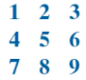

Order for convolution:

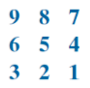

# 3 Low-level filters


In this section, you will design common linear filters used in neighborhood processing. We will focus in particular on Gaussian and Gabor filters.

## 3.1 Gaussian Filters

### 3.1.1 1D Gaussian Filter



The 1D  Gaussian filter is defined as follows:
<center>
$ G_{\sigma}(x)=\frac{1}{\sigma\sqrt{2\pi}}\text{ exp}(-\frac{x^2}{2\sigma^2}),$
</center>
where $\sigma$ is the variance of the Gaussian. However, such formulation creates an infinitely large convolution kernel. In practice, the kernel is truncated with a `kernel_size` parameter such that $-\left\lfloor \frac{kernel\_size}{2}\right\rfloor \leq x \leq \left\lfloor \frac{kernel\_size}{2} \right\rfloor$, where $\left\lfloor . \right\rfloor$ is the floor operator. As an example, if `kernel_size` equals 3, $x \in \{ -1, 0, 1 \} $.

### Exercise 
Now, implement the following *gauss1D* function.

**Hint:** 
Do not forget to normalize your filter.

**Note:** You are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [6]:
def gauss1D(sigma, kernel_size):
    G = np.zeros((1, kernel_size))
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')

    filter_range = np.linspace(-np.floor(kernel_size/2),np.floor(kernel_size/2),kernel_size)
    G = (1 / (sigma * np.sqrt(2*np.pi))) * np.exp(-pow(filter_range,2)/(2*pow(sigma,2)))
    G = G / sum(G)
    
    return G  

In [7]:
# Run this to test your function:
assert np.all(np.round(gauss1D(2,5), 4) == [0.1525, 0.2218, 0.2514, 0.2218, 0.1525]) # check if values are close enough if assert gives error

### 3.1.2 2D Gaussian Filter



One of the most important properties of 2D Gaussian kernels is separability. Therefore, convolving an image with a 2D Gaussian is equivalent to convolving
the image twice with a 1D Gaussian filter, once along the x-axis and once along the y-axis **separately**. A 2D Gaussian kernel can then be defined as a product of two 1D Gaussian kernels:
<center>
$
G_{\sigma}(x, y) = G_{\sigma}(x) \times G_{\sigma}(y)$ *(Eq. A)*

$
 = \frac{1}{\sigma^2 2\pi}\text{ exp}(-\frac{x^2 + y^2}{2\sigma^2})
 $ *(Eq. B)*
 </center>

### Exercise 

Implement `gauss2D` function that corresponds to *Eq. A* (not *Eq. B*) and you should make use of `gauss1D`.

**Note:** Again, you are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [8]:
def gauss2D(sigma_x, sigma_y, kernel_size):

    Gx = gauss1D(sigma_x, kernel_size)
    Gy = gauss1D(sigma_y, kernel_size)
    
    Gx = Gx.reshape(kernel_size, 1)
    Gy = Gy.reshape(1, kernel_size)
    
    G = Gx * Gy
    
    return G

In [9]:
# Run this to test your function:
assert np.all( np.round(gauss2D(2, 2, 3) , 4) == [[0.1019, 0.1154, 0.1019],
       [0.1154, 0.1308, 0.1154],
       [0.1019, 0.1154, 0.1019]])

In [10]:
#Eq. B 
def gaussian_filter(kernel_size, sigma=1):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
 
    x, y = np.meshgrid(np.linspace(-int(kernel_size/2), int(kernel_size/2), kernel_size),
                       np.linspace(-int(kernel_size/2), int(kernel_size/2), kernel_size))
 
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gauss = np.exp(-((x**2+y**2) / (2.0 * sigma**2))) * normal
    return gauss

In [11]:
kernel_size = 9
gaussian = gaussian_filter(kernel_size)
print("gaussian filter of{} X {} :".format(kernel_size, kernel_size))
print(np.round(gaussian, 3))

gaussian filter of9 X 9 :
[[0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.002 0.001 0.    0.    0.   ]
 [0.    0.    0.003 0.013 0.022 0.013 0.003 0.    0.   ]
 [0.    0.001 0.013 0.059 0.097 0.059 0.013 0.001 0.   ]
 [0.    0.002 0.022 0.097 0.159 0.097 0.022 0.002 0.   ]
 [0.    0.001 0.013 0.059 0.097 0.059 0.013 0.001 0.   ]
 [0.    0.    0.003 0.013 0.022 0.013 0.003 0.    0.   ]
 [0.    0.    0.    0.001 0.002 0.001 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [12]:
np.round(gauss2D(1, 1, 9) , 3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.002, 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.003, 0.013, 0.022, 0.013, 0.003, 0.   , 0.   ],
       [0.   , 0.001, 0.013, 0.059, 0.097, 0.059, 0.013, 0.001, 0.   ],
       [0.   , 0.002, 0.022, 0.097, 0.159, 0.097, 0.022, 0.002, 0.   ],
       [0.   , 0.001, 0.013, 0.059, 0.097, 0.059, 0.013, 0.001, 0.   ],
       [0.   , 0.   , 0.003, 0.013, 0.022, 0.013, 0.003, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.002, 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

#### Question (5pts)
What is the difference between convolving an image with (1) a 2D Gaussian kernel and (2) a 1D Gaussian kernel in the x- and y-direction? Will the result be the same? What is their computational complexity?

<font color = 'red'> **Answer:** </font>
There are two methods to get an image filtered with a 2-D Gaussian filter, as the formula is linear shift invariant and therefore, both yield the same result.
O(n*m) is the complexity of the 2-D Gaussian filter when applied on an input image with n-pixels length and m-pixels width. This method is described by Equation A. 

To obtain the 2-D filter we can equivalently apply the sequantial 1-D filters on the two axes. In this case, it is required to compute n operations for the lines and m operations for the columns. Therefore its complexity is O(n+m), which is signifcantly lower than the 2-D one. This method is described by Equation B. 

$\begin{aligned} G_\sigma(x, y) &=\frac{1}{2 \pi \sigma^2} \exp -\frac{x^2+y^2}{2 \sigma^2} (Eq. A)\\ &=\left(\frac{1}{\sqrt{2 \pi} \sigma} \exp ^{\left.-\frac{x^2}{2 \sigma^2}\right)}\left(\frac{1}{\sqrt{2 \pi} \sigma} \exp ^{-\frac{y^2}{2 \sigma^2}}\right)\right.(Eq. B)\end{aligned} $


### 3.1.3 Gaussian Derivatives
So far the Gaussian kernels that we computed are mainly targeted to image enhancement algorithms (e.g. denoising an image). These kernels can also be used for detecting changes in the image intensity pixels. These low-level features can then further be used as building blocks for more complicated tasks like object detection or segmentation.


Concretely, the  first order derivative of the 1D Gaussian kernel is given by:

<center>
$
\frac{d}{dx}G_\sigma(x)  =\frac{d}{dx}\left( \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2}) \right )$

$
 = -\frac{x}{\sigma^3\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2})$ 
*(Eq. C)*

 $
 = -\frac{x}{\sigma^2}G_\sigma(x)
 $
</center>
Similarly, the first order derivative of the 2D Gaussian kernel can be obtained by computing $\frac{d}{dx}G_\sigma(x,y)$ and $\frac{d}{dy}G_\sigma(x,y)$.

#### Question (5pts)
A second order derivative of the Gaussian kernel can also be computed. Why
is it interesting to design a second order kernel?

<font color = 'red'> **Answer:** </font> The second order derivativate of the Gaussian kernel (LoG - Laplacian of Gaussian) is used for edge detection in images as it follows.

We consider the pixels of the image being the signal, on which we apply the kernel filter. The first order derivative, applied on the signal, indicates the changes in values with local maxim, but not directly the edges. The LoG directly indicates if a pixel is on an edge or not, as it will result in 0 values in such cases.


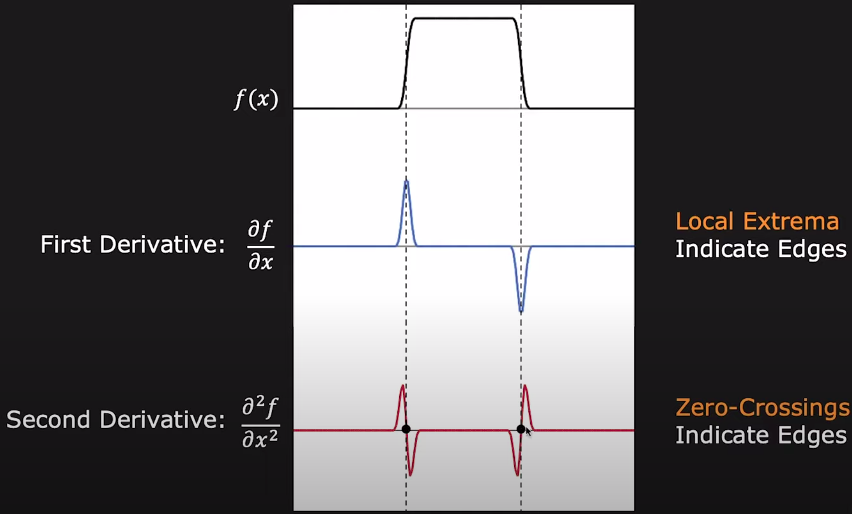

## 3.2 Gabor filters


Gabor filters fall into the category of linear filters and are widely used for *texture analysis*. The reason why they are a good choice for texture analysis is that they localize well in the frequency spectrum (*optimally* bandlimited) and therefore work as flexible *band-pass* filters.

In the following image you can see even (cosine-modulated) and odd parts (sine-modulated) of Gabor filters with fixed-σ Gaussian. You can observe time-domain filters for the modulating sinusoidals of central frequencies, 10, 20, 30, 40 and 50 Hz, respectively.


![](https://drive.google.com/uc?export=view&id=1wv6ZUOfiHMDgg0jW7n5lqkaFiFztjnEo)

Gabor filters with varying center frequencies are sensitive to different
frequency bands. Notice that the neighboring (in the frequency spectrum) filters minimally interfere with each other.

![](https://drive.google.com/uc?export=view&id=1hUQaKE_TwC-9_jMIao1CCxyjembMrUab)

### 3.2.1 1D Gabor Filters

For the sake of simplicity, we start by studying what a Gabor function is using 1D signals (e.g. speech). The idea will later be generalized to the 2D case, which is suited for our primary interest, images. A Gabor function is a Gaussian function modulated with a complex sinusoidal carrier signal. Let us denote the Gaussian with $x(t)$ and complex sinusoidal with $m(t)$. Then, a Gabor function $g(t)$ can be formulated by:

$
g(t) = x(t) m(t)   
$ *(Eq. D)*

where $x(t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}}$ and $m(t)=e^{j 2 \pi f_c t} = e^{j w_c t}$. $\sigma$ is the parameter determining the spread of the Gaussian and $w_c$ is the central frequency of the carrier signal.


---


**Hint:**
A complex sinusoidal can be represented as follows using the *Euler's formula*:
$e^{jwt} = \cos(wt) + j\sin(wt)$


---



Using Euler's formula, we get the following:
\begin{align}
    g(t) &= x(t)m(t) \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} e^{j w_c t} \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} [\cos(w_c t) + j\sin(w_c t)]
\end{align}
We can further arrange the terms and arrive at the following form
\begin{align}
    g(t) = g_e(t) + jg_o(t)
\end{align}
where $g_e(t)$ and $g_o(t)$ are the even and odd parts arranged orthogonally on the complex plane $\mathbf{Z}^2$. In practice, one can use either the even or the odd part for filtering purposes (or one can use the complex form).  

### 3.2.2 2D Gabor Filters


The Gabor filters can also be defined in 2D as well. The main difference lies in the dimensionality of the signals (i.e. carrier and gaussian). A sine wave in 2D is described by two orthogonal spatial frequencies $u_0$ and $v_0$ such that it is given as $s(x,y) = sin(2\pi(u_0 x + v_0 y))$ where a 2D gaussian is simply $C e^{-(\frac{(x-x_0)^2}{2\sigma_x^2}) + \frac{(y-y_0)^2}{2\sigma_y^2})}$ with $C$ being a normalizing constant. 2D Gabor function then takes the following forms in the real and complex parts:

\begin{align}
    g_{real}(x,y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\cos\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)                                              
\end{align}
\begin{align}
g_{im}(x,y; \lambda, \theta, \psi, \sigma, \gamma) &= \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\sin\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)
\end{align}

where
\begin{align}
    x^\prime &= x\cos\theta + y\sin\theta \\
    y^\prime &= -x\sin\theta + y\cos\theta
\end{align}

#### Question 4 (5pts)
Conduct a self-study on the Gabor filters. Explain shortly what the parameters $\lambda, \theta, \psi, \sigma, \gamma$ control.

<font color = 'red'> **Answer:** </font>

λ - the wavelength of the sinusoidal component. This impacts the width of the strips in the function graphic representation. The higher wavelength is the thicker the stripes produced by the wavelength will be.

θ - the orientation of the normal to the parallel stripes of Gabor function. When θ is 0 the Gabor function is positioned vertically and when θ is 90 the function has a horizontal shape.

ψ - the phase offset of the Gabor function which has a sinusoidal shape

σ - the bandwith impacts the size of the Gabor function envelope. For a small sigma value, the function will look like a singular line, whilst for a high value more paralel stripes will appear.

γ - the aspect ratio of the Gabor function. It influences the height of the function such that the higher gamma value the smaller the height of the function for the same values of the other parameters.   


### Exercise 

##### Design array of Gabor Filters

Now, you will create a Gabor Filterbank. A filterbank is a collection of filters with varying properties (e.g. {shape, texture}). A Gabor filterbank consists of Gabor filters of distinct orientations and scales. We will use this bank to extract texture information from the input image. 

Your task is to implement function `createGabor` but to do that you will need some helper functions, which are defined below. Finish the implementation of those and then use them in `createGabor`.

In [39]:
def generateRotationMatrix(theta):
    # Returns the rotation matrix. 
    # Hint: https://en.wikipedia.org/wiki/Rotation_matrix

    rotMat = np.array([[np.cos(theta), -np.sin(theta)], 
            [np.sin(theta), np.cos(theta)]])
    return rotMat

In [38]:
def createCos(rot_x, lamda, psi):
    # Returns the 2D cosine carrier. 

    cosCarrier = np.cos(((2*np.pi)*(rot_x/lamda))+psi)

    # Reshape the vector representation to matrix.
    cosCarrier = np.reshape(cosCarrier, (np.int32(np.sqrt(len(cosCarrier))), -1))
    return cosCarrier

In [37]:
def createSin(rot_x, lamda, psi):
    # Returns the 2D sine carrier. 

    sinCarrier = np.sin(((2*np.pi)*(rot_x/lamda))+psi)

    # Reshape the vector representation to matrix.
    sinCarrier = np.reshape(sinCarrier, (np.int32(np.sqrt(len(sinCarrier))), -1))
    return sinCarrier

In [36]:
def createGauss(rot_x, rot_y, gamma, sigma):
    # Returns the 2D Gaussian Envelope. 

    gaussEnv = np.exp(-((np.square(rot_x)+np.square(gamma)*np.square(rot_y))/(2*np.square(sigma))))

    return gaussEnv

Implement the function `createGabor` using above helper functions and equations for $g_{real} $ and $g_{im}$. 


In [34]:
def createGabor(sigma, theta, lamda, psi, gamma):
	'''
	Creates a complex valued Gabor filter.
	myGabor = createGabor(sigma, theta, lamda, psi, gamma) generates Gabor kernels. 
	:param sigma: Standard deviation of Gaussian envelope.
	:param theta: Orientation of the Gaussian envelope. Takes arguments in the range [0, pi/2).
	:param lamda: The wavelength for the carriers. The central frequency (w_c) of the carrier signals.
	:param psi: Phase offset for the carrier signal, sin(w_c . t + psi).
	:param gamma: Controls the aspect ratio of the Gaussian envelope
	:return: myGabor - A matrix of size [h,w,2], holding the real and imaginary 
						parts of the Gabor in myGabor(:,:,1) and myGabor(:,:,2), respectively.
	'''
							
	# Set the aspect ratio.
	sigma_x = sigma
	sigma_y = float(sigma)/gamma

	# Generate a grid
	nstds = 3
	xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
	xmax = np.ceil(max(1,xmax))
	ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
	ymax = np.ceil(max(1,ymax))

	# Make sure that we get square filters. 
	xmax = max(xmax,ymax)
	ymax = max(xmax,ymax)
	xmin = -xmax 
	ymin = -ymax

	# Generate a coordinate system in the range [xmin,xmax] and [ymin, ymax]. 
	[x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

	# Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
	XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)

	# Compute the rotation of pixels by theta.
	# Hint: Create appropriate rotation matrix to compute the rotated pixel coordinates: rot(theta) * XY.
	rotMat = generateRotationMatrix(theta)
	rot_XY = np.matmul(rotMat, XY)
	rot_x = rot_XY[0,:]
	rot_y = rot_XY[1,:]
	

	# Create the Gaussian envelope.
	# IMPLEMENT the helper function createGauss above.
	gaussianEnv = createGauss(rot_x, rot_y, gamma, sigma)

	# Create the orthogonal carrier signals.
	# IMPLEMENT the helper functions createCos and createSin above.
	cosCarrier = createCos(rot_x, lamda, psi)
	sinCarrier = createSin(rot_x, lamda, psi)


	# Modulate (multiply) Gaussian envelope with the carriers to compute 
	# the real and imaginary components of the complex Gabor filter. 
	gaussianEnv = np.reshape(gaussianEnv, (-1, cosCarrier.shape[0])) #reshape gaussEnv to match Carrier
	myGabor_real = gaussianEnv * cosCarrier  # TODO: modulate gaussianEnv with cosCarrier
	myGabor_imaginary = gaussianEnv * sinCarrier  # TODO: modulate gaussianEnv with sinCarrier
	
	# Pack myGabor_real and myGabor_imaginary into myGabor.
	h, w = myGabor_real.shape
	myGabor = np.zeros((h, w, 2))
	myGabor[:,:,0] = myGabor_real
	myGabor[:,:,1] = myGabor_imaginary

	# Uncomment below lines from "fig = plt.figure()" to see how are the gabor filters
	# figure
	# subplot(121), imshow(myGabor_real,[])
	# subplot(122), imshow(myGabor_imaginary, [])

# 	fig = plt.figure()
# 	ax = fig.add_subplot(1, 2, 1)
# 	ax.imshow(myGabor_real)    # Real
# 	ax.axis("off")
# 	ax = fig.add_subplot(1, 2, 2)
# 	ax.imshow(myGabor_imaginary)    # Real
# 	ax.axis("off")

	return myGabor

#### Question (5pts)
Visualize how the parameters $\theta$, $\sigma$ and $\gamma$ affect the filter in spatial domain. 

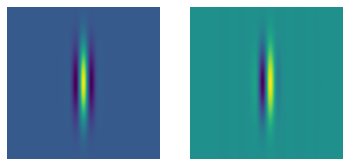

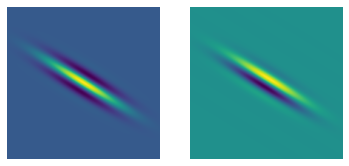

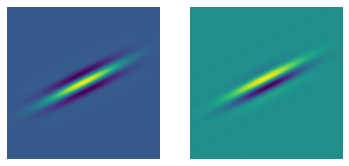

In [29]:
#this standard values are used in order to test the influence of the three parameters
sigma = 10
theta = 0
lamda = 30
psi = 0
gamma = 0.25

#Changing value of Theta using 3 examples
(createGabor(sigma=10,theta=0,lamda=30,psi=0,gamma=0.25))
(createGabor(sigma=10,theta=45,lamda=30,psi=0,gamma=0.25))
(createGabor(sigma=10,theta=90,lamda=30,psi=0,gamma=0.25));



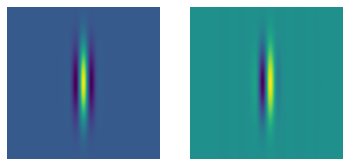

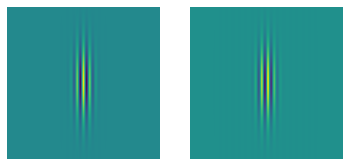

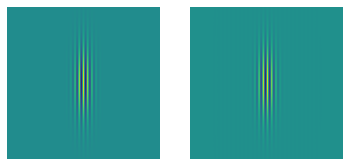

In [30]:
#Changing value of sigma using 3 examples
(createGabor(sigma=10,theta=0,lamda=30,psi=0,gamma=0.25))
(createGabor(sigma=30,theta=0,lamda=30,psi=0,gamma=0.25))
(createGabor(sigma=45,theta=0,lamda=30,psi=0,gamma=0.25));



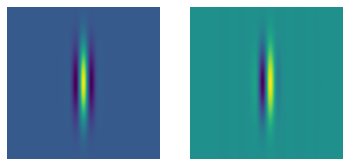

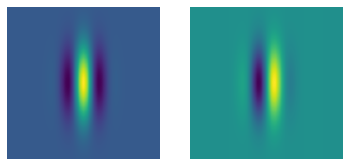

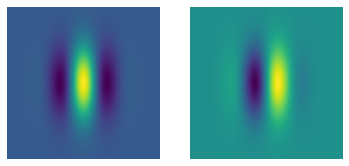

In [31]:
#Changing value of gamma using 3 examples
(createGabor(sigma=10,theta=0,lamda=30,psi=0,gamma=0.25))
(createGabor(sigma=10,theta=0,lamda=30,psi=0,gamma=0.50))
(createGabor(sigma=10,theta=0,lamda=30,psi=0,gamma=0.75));



ANSWER:

- Theta value corresponds to the degree of the filter and thus controls the orientation of the filter
- Sigma value controls the size of the filter, higher value means more stripes which are thinner
- Gamma value is the aspect ratio and controls the height of the filter. For very high aspect ratio the height becomes very small and for very small gamma value the height becomes quite large


# 4 Applications in image processing 

## 4.1 Noise in digital images

The quality of digital images can be affected in different ways. For example, the
acquisition process can be very noisy and with a low-resolution (e.g. some medical
imaging modalities only generate a 128x128 image). Noise can also come from the
user who set wrong parameters on the digital camera. Consequently, different computer vision algorithms are required to enhance noisy or corrupted images. With the
growing amount of photos taken every day, image enhancement has then become a
very active area of research.

In this section, we only focus on simple algorithms to correct noise coming typically from the sensor of your camera. Many other types of noise or corruption can happen but are out of the scope of this assignment.

### 4.1.1 Salt-and-pepper noise

Noise can also occur with over-exposition causing a ”hot” pixel or with a defective
sensor causing a ”dead” pixel. This is called salt-and-pepper noise. Pixels in the
image are randomly replaced by either a white or black pixel.

### 4.1.2 Additive Gaussian noise

Noise also occurs frequently when the camera heats up. This is called thermal noise
and this can be modeled as an additive Gaussian noise. Every pixel in the image
has a noise component that corresponds to a random value chosen independently
from the same Gaussian probability distribution. The Gaussian distribution has a
mean of 0 and its standard deviation corresponds to a parameter.

\begin{equation}
\begin{array}{rl}
\mathbf{I}^{\prime}(x) = \mathbf{I}(x) + \epsilon \text{, where } \epsilon \sim  \mathcal{N}(0, \sigma^2)
\end{array}
\end{equation}

where $\mathbf{I}^{\prime}$ is the noisy image and $\mathbf{I}$ is the original image without any noise $\epsilon$.

## 4.2 Image denoising

### 4.2.1 Quantitative evaluation

The peak signal-to-noise ratio (PSNR) is a commonly used metric to quantitatively evaluate the performance of image enhancement algorithms. It is derived from the mean squared error (MSE):

\begin{equation}
\begin{array}{rl}
MSE = \frac{1}{m \cdot n}\sum\limits_{x,y}\Big[\mathbf{I}(x,y) - \mathbf{\hat{I}}(x,y)\Big]^2
\end{array}
\end{equation}
where $\mathbf{I}$ is the original image of size $m\times n$ and $\mathbf{\hat{I}}$ its approximation (i.e. in our case an enhanced corrupted image). The PSNR corresponds to:

\begin{equation}
\begin{split}
PSNR & = 10 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}^2}{MSE}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{\sqrt{MSE}}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{RMSE}\Big)
\end{split}
\end{equation}
where $\mathbf{I}_{max}$ is the maximum pixel value of $\mathbf{I}$ and RMSE is the root of the MSE.



#### Exercise

Implement **myPSNR**

**Note:** You are not allowed to use the Python built-in functions provided in *PIL* and *Skimage*.

In [18]:
def myPSNR(orig_image, approx_image):
    """
    ================
    Your code here
    ================
    """
    
    orig_image = orig_image.astype('float32')
    approx_image = approx_image.astype('float32')
    
    # All the channels are the same, so we are taking only one
    MSE = (np.sum((np.mean(orig_image, axis = 2) - np.mean(approx_image, axis = 2))**2) / 
                 (orig_image.shape[0] * orig_image.shape[1]))

    
    PSNR = 20 * np.log10(255 / np.sqrt(MSE)) #we use 255 as Imax (from piazza: https://piazza.com/class/l79aso6izja7l3/post/68)

    return PSNR

### Questions (10 pts)
1.   Explain briefly in your own words what the PSNR is (without any equations). When comparing different methods with the PSNR metric, is a higher value the better or the opposite?


<font color = 'red'> **Answer:** </font> *PSNR is the ratio between maximum signal power and the power of the noise which affects the representation of the image. In general PSNR is used to compare the quality of original image and resulting image after applying the filters. Higher the value of PSNR indicates better approximation.*

2.   Using your implemented function **myPSNR**, compute the PSNR between image1_saltpepper.jpg and image1.jpg. What PSNR value did you get?

  **Hint:**
Make sure that dtype of image is float32.

In [19]:
img1 = cv2.imread('./sample_data/sample_data/image1.jpg')
img_sp = cv2.imread('./sample_data/sample_data/image1_saltpepper.jpg')
PSNR = myPSNR(img1, img_sp)
PSNR

15.532208785227796

<font color = 'red'> **Answer:** </font> **PSNR = 15.532208785227796**

3.   Using your implemented function **myPSNR**, compute the PSNR between image1_gaussian.jpg and image1.jpg. What PSNR value did you get?

In [467]:
img1 = cv2.imread('./sample_data/sample_data/image1.jpg')
img_gauss = cv2.imread('./sample_data/sample_data/image1_gaussian.jpg')
PSNR = myPSNR(img1, img_gauss)
PSNR

17.170831127299063

<font color = 'red'> **Answer:** </font> **PSNR = 17.170831127299063**

### 4.2.2 Neighborhood processing for image denoising

We will now design filters to remove these two types of noise. The function will denoise the image by either applying:

1. *box filtering*: You can use **cv2.blur** function.
2. *median filtering*: You can use **cv2.medianBlur** function.
3. *Gaussian filtering*: You must use your **cv2.GaussianBlur** function.

#### Exercise

Implement **denoise**

**Hints:** 
1. **kernel_type** is just a string to specify the kernel type.
2. ****kwargs** allows to have an undefined key-value pairs in a Python function. For example, you can have **sigma** and  **kernel_size** as argument when using a Gaussian kernel but only **kernel_size** when using a box kernel. For more information about how ****kwargs** works, take a look at [usage of kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

In [380]:
def denoise(image, kernel_type, **kwargs):
    if kernel_type == 'box':
        imOut = cv2.blur(image, ksize = kwargs['ksize'])
    elif kernel_type == 'median':
        imOut = cv2.medianBlur(image, ksize = kwargs['ksize'])
    elif kernel_type == 'gaussian':
        imOut = cv2.GaussianBlur(image, ksize = kwargs['ksize'], sigmaX = kwargs['sigmaX']) #ask about sigmaX
    else:
        print('Operation Not implemented')
    return imOut

### Question (20 pts)
1.   Using your implemented function **denoise**, try denoising image1_saltpepper.jpg and image1_gaussian.jpg by applying the following filters:

      (a) Box filtering of size: 3x3, 5x5, and 7x7.

      (b) Median filtering with size: 3x3, 5x5 and 7x7.

     Show the denoised images in the cell below. You can use tables to present your quantitative results.



<font color = 'red'> **Note:** </font> *Results for PSNR are provided below every image. The table with the results is included in the answer for the next question*

<font color = 'red'> **(a)** </font>

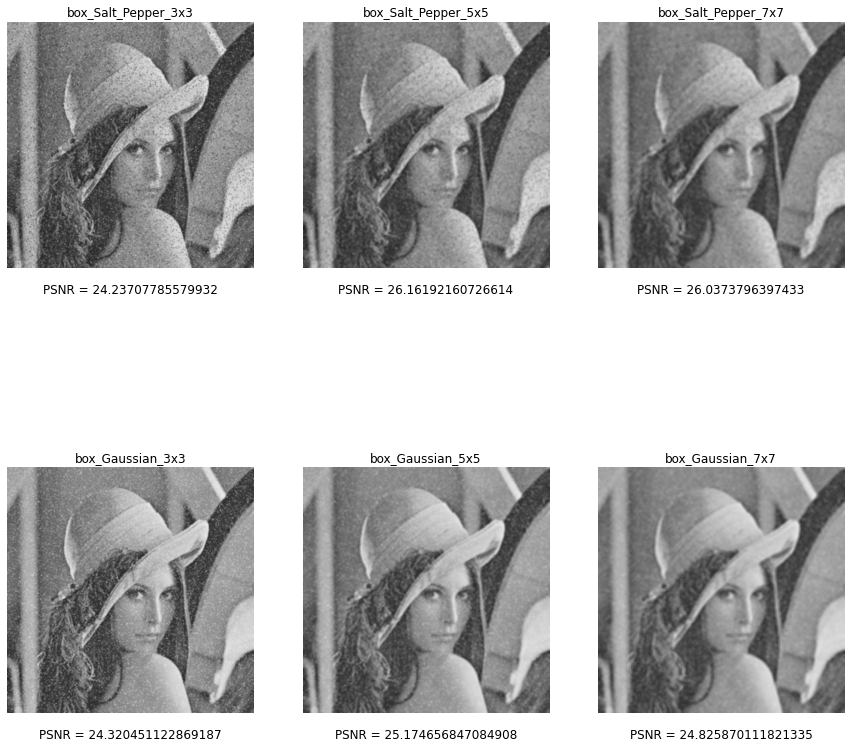

In [475]:
input_images = {'salt_pepper': img_sp, 'gaussian': img_gauss}
ksizes = {'3x3' : (3,3), '5x5': (5,5), '7x7': (7,7)}
comparison(img1, input_images, ksizes, 'box')

<font color = 'red'> **(b)** </font>

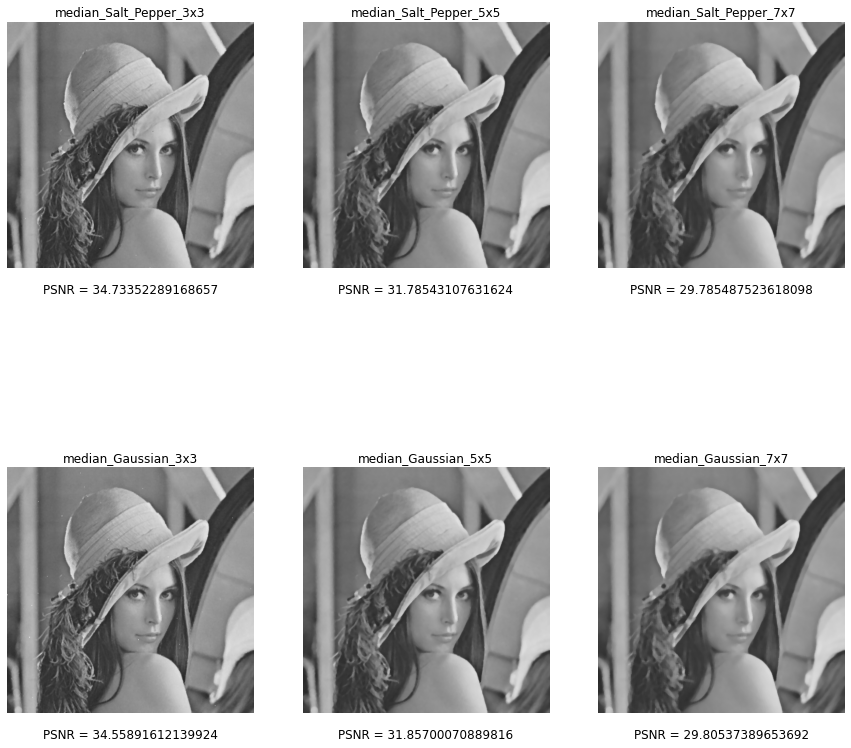

In [476]:
input_images = {'salt_pepper': img_sp, 'gaussian': img_gauss}
ksizes = {'3x3' : 3, '5x5': 5, '7x7': 7}
comparison(img1, input_images, ksizes, 'median')

2.   Using your implemented function **myPSNR**, compute the PSNR for every denoised image (12 in total) wrt the original image. What is the effect of the filter size on the PSNR? Report the results (in a table) and discuss.

<font color = 'red'> **Answer:** </font> 

#### Image 1 - SaltPepper
| Filter type \ Filter size| 3x3 | 5x5 | 7x7 |
| --- | --- | --- | --- |
| **Box** | 24.23707785579932 | 26.16192160726614 | 26.0373796397433 |
| **Median** | 34.73352289168657 | 31.78543107631624 | 29.785487523618098 |

#### Image 1 - Gaussian
| Filter type \ Filter size| 3x3 | 5x5 | 7x7 |
| --- | --- | --- | --- |
| **Box** | 24.320451122869187 | 25.174656847084908 | 24.825870111821335 |
| **Median** | 34.55891612139924 | 31.85700070889816 | 29.80537389653692 |

*As we can see in the tables above, when comparing PSNR for box filter, in both cases best value was obtained for size 5x5. On the other hand for median filter best results are for size 3x3. We can also observe that in both cases the best result was obtained for median filter of size 3x3 and the worst for box filter of size 3x3*

3.   Which is better for the salt-and-pepper noise, box or median filters? Why? What about the Gaussian noise?


<font color = 'red'> **Answer:** </font> *According to https://books.google.com/books?id=ttNuj2mmt4sC&pg=PA272 when the image is corrupted by impulse noise i.e. salt-and-pepper noise the box filter attenuates and diffuses the noise instead of removing it. In that case median filter is more effective to minimize the noise. We can also observe that in our results. For gaussian noise reduction, we may use box, median or gaussian filter. In our example median filter worked better than box filter. For both images, according to PSNR better are median filters. Regardless of the filter size, PSNR is higher for median filter*


4.   Try denoising image1_gaussian.jpg using a Gaussian filtering. Choose an appropriate window size and standard deviation and justify your choice. Show the denoised images in the cell below.


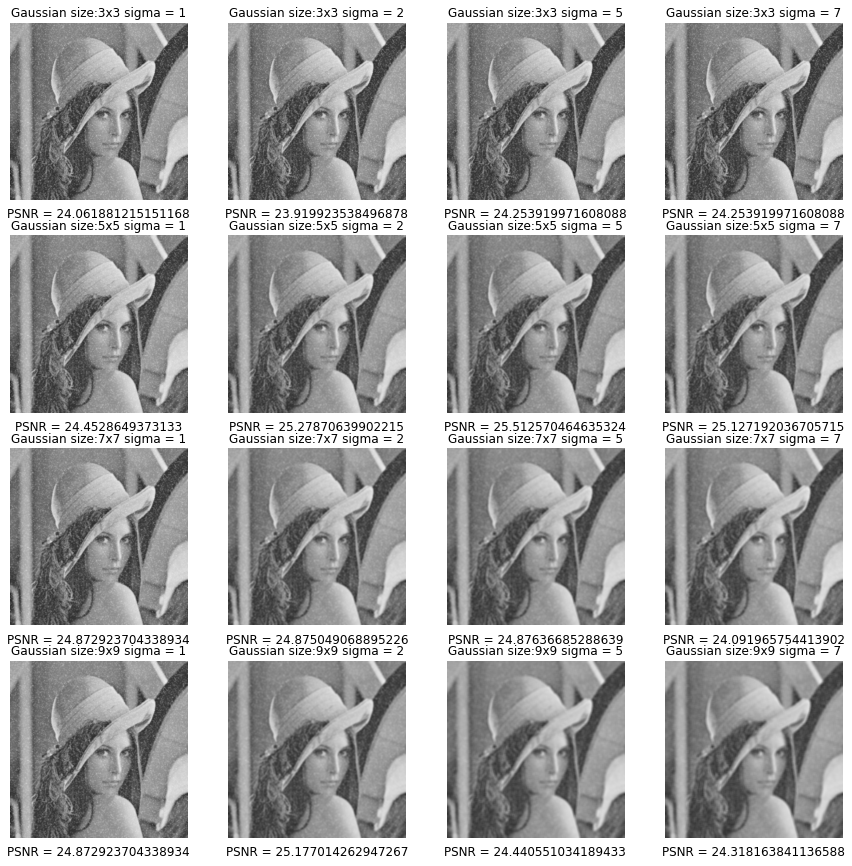

In [412]:
sigmas = [1, 2, 5, 7]
ksizes = {'3x3' : (3,3), '5x5': (5,5), '7x7': (7,7), '9x9': (9, 9)}
comparison_gaussian(img1, img_gauss, ksizes, sigmas)

<font color = 'red'> **Answer:** </font> *We decided to experiment with 4 window sizes and 4 sigma values. During experimentation it turned out that increasing or decreasing the sigma value further does not have the positive effect on PSNR value. Best result was obtained for filter size = 5x5 and sigma = 5*


5.   What is the effect of the standard deviation on the PSNR? Report the results (in a table) and discuss.


| Filter size \ sigma| sigma = 1 | sigma = 2 | sigma = 5 | sigma = 7 |
| --- | --- | --- | --- | --- |
| 3x3 | 24.061881215151168 | 23.919923538496878 | 24.253919971608088 | 24.253919971608088 |
| 5x5 | 24.4528649373133 | 25.27870639902215 | 25.512570464635324 | 25.127192036705715 |
| 7x7 | 24.872923704338934 | 24.875049068895226 | 24.87636685288639 | 24.091965754413902 |
| 9x9 | 24.872923704338934 | 25.177014262947267 | 24.440551034189433 | 24.318163841136588 |

<font color = 'red'> **Answer:** </font> *In general sigma parameter in Gaussian filter is responsible for how wide the kernel function will be. The higher the sigma the bigger blur will be. As we can see in the table above, sigma does not follow any particular rule. As we can see in the table above the best result was for the size (5x5) and sigma = 5. On the other hand the worst result was calculated for size = 3x3 and sigma = 3. We can also see some correlation between sigma and box size. For bigger box sizes bigger sigma performs better (not in all cases)*


6.   What is the difference among median filtering, box filtering and Gaussian filtering? Briefly explain how they are different at a conceptual level. If two filtering methods give a PSNR in the same ballpark, can you see a qualitative difference?

<font color = 'red'> **Answer:** </font> *Median, Box and Gaussian filters are all neighbourhood operations. All of the methods are types of spatial filtering which involves passing a kernel over the image and replacing the original value of the pixel (center of the kernel) with the sum of pixels values within the kernel multiplied by kernel weights.*

**Box filter:** *Replaces the original pixel value with the average of all the values in the neighbourhood.*

**Median filter:** *Replaces the original pixel value with the median of all the values in the neighbourhood.*

**Gausiann filter:** *Replaces the original pixel value using normal distribution. The weights for the kernel are chosen according to the shape of Gaussian function. The Gaussian filter in 2D is given by following funtion:*

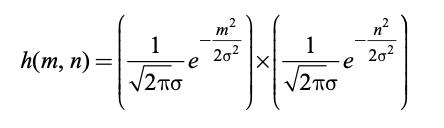

*If the PSNR is similar we should decide which characteristics of the original image we would like to preserve, but also take into account with what type of noise are we dealing with. For example Box filtering leads to the blurring of an image, which affects feature localisation. It is also sensitive to outliers so using it with salt pepper noise wouldn't be best idea. In this example median filter will be best to use. On the other hand when we are dealing with some kind of noise drawn from the normal distribution it will be probably best to use Gaussian filter.*


## 4.3 Edge detection

Edges appear when there is a sharp change in brightness. In an image this usually corresponds to the boundaries of an object. Edge detection is a fundamental task used in many computer vision applications. One of them is road detection in autonomous driving, which is used for determining the vehicle trajectory.

Many different techniques exist for computing the edges. In this section, we will focus on filters that extract the gradient of the image. We will try to detect the road in an still image.

### 4.3.1 First-order derivative filters


**Sobel** kernels approximate the first derivative of a Gaussian filter. Below are the Sobel kernels used in the $x$ and $y$ directions.

\begin{equation}
\begin{array}{rl}
G_x = \begin{bmatrix} +1 & 0 & -1 \\ +2 & 0 & -2 \\ +1 & 0 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}

\begin{equation}
\begin{array}{rl}
G_y = \begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}
The gradient magnitude is defined as the square root of the sum of the squares of the horizontal ($G_x$) and the vertical ($G_y$) components of the gradient of an image, such that: 
\begin{equation}
G =\sqrt {{G_x}^2+{G_y}^2}
\end{equation}
The gradient direction is calculated as follows:
\begin{equation}
\theta= \tan ^{ - 1}{\frac{G_y}{G_x}}
\end{equation}


### Question (10 pts)
Using your implemented function **compute_gradient** on image2.jpg, display the following figures:

  1. The gradient of the image in the x-direction.

  2. The gradient of the image in the y-direction.

  3. The gradient magnitude of each pixel.

  4. The gradient direction of each pixel.

Discuss what kind of information every image conveys.



> 1. The gradient of the image in the x-direction gives the horizontal edges. It shows the edges that can be found along the horizontal axis. Meaning that mainly vertical edges appear. In other words, if you follow the image line by line, from left to right, horizontal edges may not be found, because they align with the horizontal line. Vertical edges however are perpendicular to the horizontal line, which makes them stand out. Diagonal lines work similarly, they are alternately horizontal and vertical, and the vertical parts are picked up by tracing the image from left to right. The image below is the gradient in the x-direction:

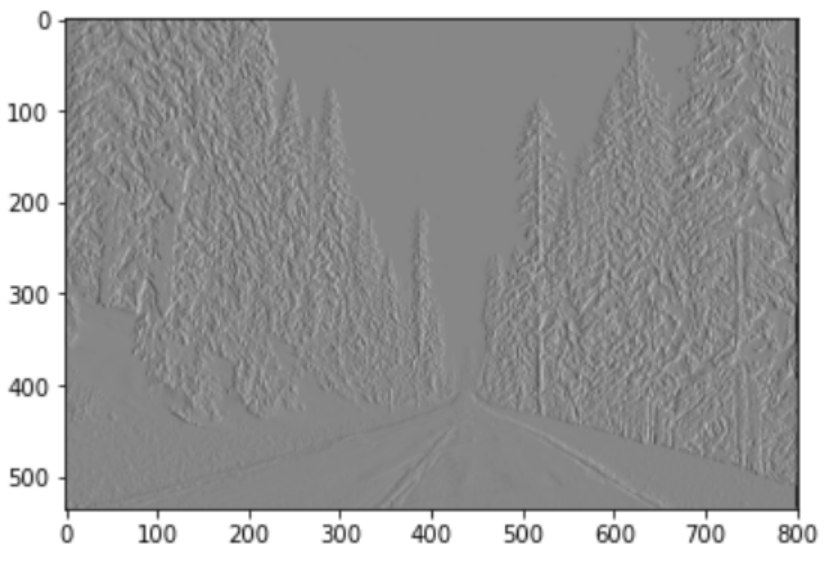

> 2. The gradient of the image in the y-direction gives the vertical edges. This works very similar to the gradient in the x-direction, except that the image isn't observed in lines from left to right, but in lines from top to bottom. Which can make vertical lines disappear, because they might exactly follow the observation-line, which means there is no contrast or edge detetcted at that specific point. The horizontal edges can be detected with this gradient-image, because now they are perpendicular to the (vertical) lines that are being traced on the image. The diagonal lines are spotted here as well, because of the exact same reason as with the gradient in the x-direction. The image below shows what the gradient in the y-direction looks like:

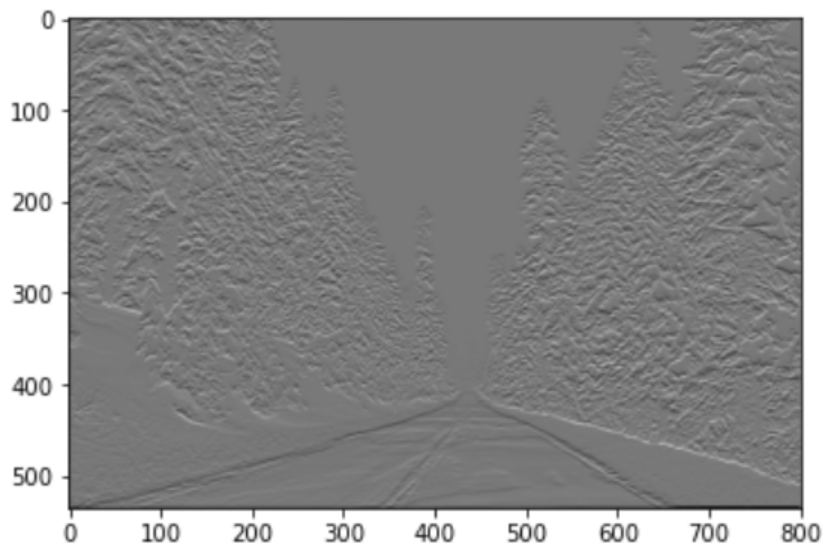

> 3. The gradient magnitude of each pixel. Magnitude can be explained as the brightness. And since it is the gradient magnitude (based on the two images above, that showed the horizontal and vertical edges), the image below shows the brightness of the edges in the image. If there is no edge however, there can be no brightness of the edge either. The original picture for example shows a very bright sky, but (as can be seen on the two gradient-images as well as the gradient magnitude-image) the sky has no edges. 
The two images with the gradient show darker (negative) and lighter (positive) edges along a neutral, grey background. In the image with the gradient magnitude, the background is black and all the edges are light. This is done by the formula, which made all the values positive: `np.sqrt(Gx**2 + Gy**2`. The image below shows what the gradient magnitude looks like:

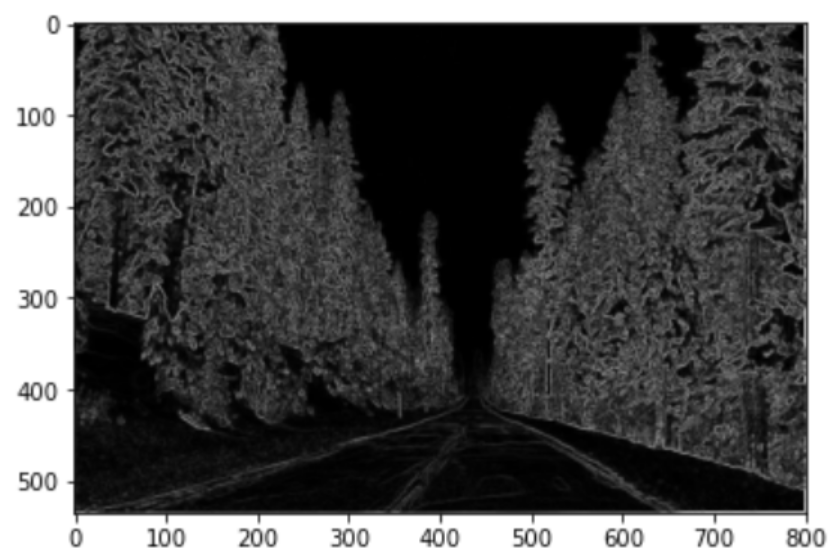

> 4. The gradient direction of each pixel. The first image showed vertical and diagonal edges and if the edge was from black to white or from white to black. The second image did this for the horizontal and diagonal lines. This fourth images puts them together per pixel. Because there are many edges in the original image, there are many pixels with a direction to be found in this image. Obviously where the trees are, since there were a lot of switches from dark to light and vice versa. But apparently the sky had a few pixels that acted like an edge too. The outline of the trees, though boxy and pixelated (obviously) can be seen very clearly. So can the edges of the road. The left-side edge has mostly light pixels, meaning that the edge went from light to dark, and the right-side edge has mostly dark pixels, meaning that the edge went from dark to light.
The image below shows the gradient direction per pixel:

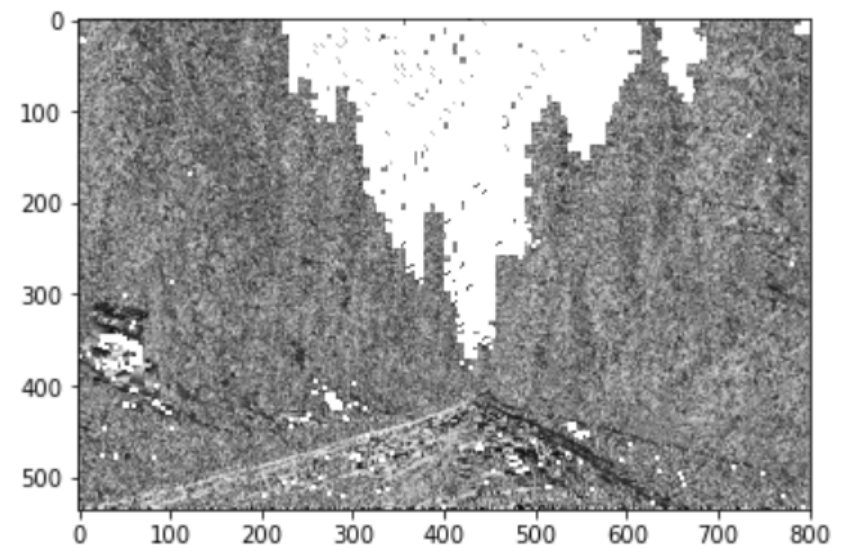

#### Exercise

Implement **compute_gradient**

**Note:** 
You are not allowed to use the Python built-in functions for computing gradient. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [20]:
from scipy.signal import convolve2d

def compute_gradient(image):
    """
    ================
    Your code here
    ================
    """

    # Gx: gradient in x direction (1)
    Sobel_x = [[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]]
    Gx = convolve2d(image, Sobel_x)
    #plt.imshow(Gx)
    
    # Gy: gradient in y direction (2)
    Sobel_y = [[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]]
    Gy = convolve2d(image, Sobel_y)
    #plt.imshow(Gy)
    
    # Magnitude of each pixel (3)
    im_magnitude = np.sqrt(Gx**2 + Gy**2)
    #plt.imshow(im_magnitude)
    
    # Direction of each pixel (4)
    im_direction = np.arctan(Gy/Gx)
    #plt.imshow(im_direction)
    
    return Gx, Gy, im_magnitude, im_direction

In [ ]:
img = cv2.imread('./sample_data/sample_data/image2.jpg', 0)
compute_gradient(img)

### 4.3.2 Second-order derivative filters

Compared to the Sobel filter, a Laplacian of Gaussian (LoG) relies on the second derivative of a Gaussian filter. Hence, it will focus on large gradients in the image. A LoG can be computed by the following three methods:



*   method 1: Smoothing the image with a Gaussian kernel (kernel size of 5 and standard deviation of 0.5), then taking the Laplacian of the smoothed image (i.e. second derivative).
*   method 2: Convolving the image directly with a LoG kernel (kernel size of 5 and standard deviation of 0.5).

*   method 3: Taking the Difference of two Gaussians (DoG) computed at different scales $\sigma_1$ and $\sigma_2$.





#### Exercise 

Implement **compute_LoG**

The function should be able to apply any of the above mentioned methods depending on the value passed to the parameter *LOG_type*

**Note:** 
You are not allowed to use the Python built-in functions for computing LOG kernels. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [25]:
from scipy.signal import convolve2d

def compute_LoG(image, LOG_type):

    if LOG_type == 1:
        #method 1: Gaussian filter & Laplacian filter
        """
        ================
        Your code here
        ================
        """
        filter = "Gaussian & Laplace"
        imGaus = convolve2d(image, Gaussian(5, 0.5))
        imOut = convolve2d(imGaus, Laplacian(5, 0.5))
        

    elif LOG_type == 2:
        #method 2: Laplace of Gaussian
        """
        ================
        Your code here
        ================
        """
        filter = "LoG"
        imOut = convolve2d(image, Laplacian(5, 0.5))
        
        
    elif LOG_type == 3:
        #method 3: Difference of Gaussian
        """
        ================
        Your code here
        ================
        """
        filter = "DoG"
        gaus_sig_1 = convolve2d(image, Gaussian(5, 0.4))
        gaus_sig_2 = convolve2d(image, Gaussian(5, 0.5))
        imOut = gaus_sig_2 - gaus_sig_1
 
        
    # show image
    fig = plt.figure()
    plt.gray()  # show the filtered result in grayscale
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.set_title("original")
    ax2.set_title(filter)
    ax1.imshow(image)   # original
    ax2.imshow(imOut)   # filtered
    plt.show()

    #return imOut

### Questions (10 pts)

1.   Test your function using image2.jpg and visualize your results using the three methods.





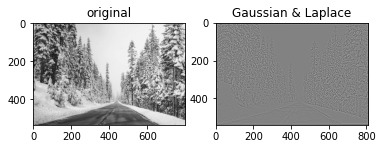

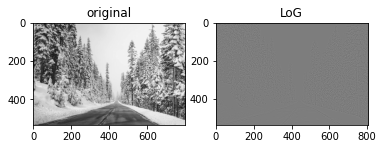

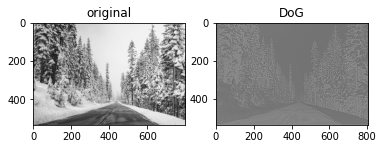

In [518]:
compute_LoG(img, 1)
compute_LoG(img, 2)
compute_LoG(img, 3)


2.   Discuss the difference between applying the three methods.


> Gaussian kernel (5x5). The image displayed below is the Gaussian filter that is computed in `Gaussian()` and used in `compute_LoG()` for both the first and the third method.

> 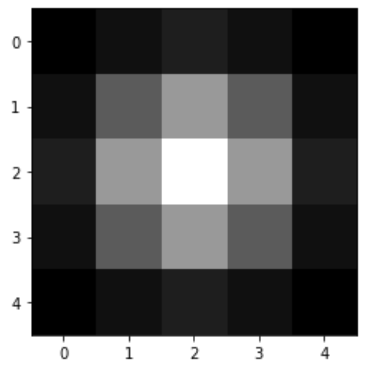

> Laplacian kernel (5x5).The image displayed below is the Laplacian filter that is selected in `Laplacian()` based on the Laplacian kernel in [the week 3 seminar questions](https://canvas.uva.nl/courses/32252/pages/exercises-week-3?module_item_id=1314086), and is used in `compute_LoG()` for both the first and the second method.

> 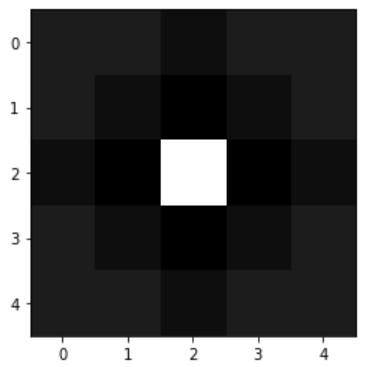

> The first method is similar to the second, mainly because they are both convolved using the Laplacian. The difference lies in the smoothing of the image, which is only done in the first method. The two output-images look very similar because of the similarities in handling the original image, except that the first method gives a clearer result in where the edges are. The effect of smoothing the image with a Gaussian beforehand is discussed further in the next question. The third method (DoG) works differently and can give very different outputs. The exact output is also dependent on the sigmas that have been used, since they are compared (by substracting them). While the first two images are mostly grey, and show the edges, the third image is (in case of the very different sigmas) black and white and seems to be a negative of the original image. If this output of the third method is used as input for the first method, the same edges are found (though lighter and darker are reversed, since that has also happened in the input image). When making the difference between the two sigmas smaller, the difference between light and dark in the output-image of the third image also become smaller. Since this does not give much of a better or worse result, other sigmas should be considered. Another example (the one that is used and displayed above) is with sigmas closer to each other. This still looks someone like a negative, but in greytones. Which better displayes the important differences between darker and lighter planes on the (original) image and thus the edges.


3.   In the first method, why is it important to convolve an image with a Gaussian before convolving with a Laplacian?



> "Blurring an image with a Gaussian and then taking its Laplacian is equivalent to convolving directly with the Laplacian of Gaussian (LoG) filter" (Computer Vision: Algorithms and Applications, 2nd Edition. Chapter 3.2.3 Band-pass and steerable filters). The first image (`compute_LoG(img, 1)`, Gaussian & Laplace) however, is slightly different than the second (`compute_LoG(img, 2`, LoG). In the first, the differences between dark and light (from the original image) are clearer than on the second, courtesy of smoothing with the Gaussian kernel. By smoothing it beforehand, some of the noise is reduced and the image becomes less pixelated. Because of this, some of the (unnecessary) edges are removed and the more important edges remain, giving a clearer result when convolving with Laplacian. This is the difference that can be seen between the first and the second method in the exercise above.

4.   In the third method, what is the best ratio between $\sigma_1$ and $\sigma_2$ to achieve the best approximation of the LoG? What is the purpose of having 2 standard deviations?



> The larger the difference between the two sigmas, the larger the differences between dark and light. But this does not mean per se that it is better. With for example `$\sigma_1$= 0.1` and `$\sigma_2$ = 1`, the image becomes a negative of the original. Now, this is used on for example smartphones and laptops if the user wishes to have an improved visibility of the screen. But when using this new image as the input for the first method (since the previous question exlained why the first emthod is preferred over the second) the output is the same as when using the orginal image (only light and dark areas are reversed). Since this does not add any value to the information we already gathered, this is not the ideal image or ratio. Making the ratio between the two smaller changes the output. The ideal ratio seemed to be `$\sigma_1$ = 0.4` and `$\sigma_2$ = 5`. The output image is in many way similar to the ones from the first and second method. It used the same grey-ish colourscheme and a lot of noise is no longer visible. This image however does provide more detail than the first two do. Making the difference between the two even smaller takes some of these details away, and making the differnce bigger shows more detail than it does now. Up to the point where there is so much additional information (details) that it can again be considered noise. Making the two sigmas equal results in a grey image, with no difference at all (which is logical, since f.e. 5-5=0, meaning there can be no differnce). And substracting $\sigma_2$ from $\sigma_1$ gives basically the same image-output, except that dark and light are reversed. The sigmas that are used in the code above, are the best ratio (`$\sigma_1$ = 0.4` and `$\sigma_2$ = 5`).

5.   What else is needed to improve the performance and isolate the road,  i.e. what else should be done? You don't have to provide any specific parameter or specific algorithm. Try to propose a direction which would be interesting to explore and how you would approach it.


> * An option that has also been mentioned in the previous answer, is to do some more mixing and matching. Meaning that the output of the third method can be used as input for the first or second method. 
> * Other options are to use differently sized kernels. In all cases the `kernel_size = (5,5)`. But a smaller size could be used for containing more detail (for example (3,3)) or a larger size for removing more detail (for example (7,7)). The road has less detail and switching of colours than the trees do (because the trees have snow on many different places, while the road only has it on the side, making for a stark difference between the road and the side of the road). A little try with applying a (3,3) Laplacian kernel instead of a (5,5) Laplacian kernel gave a less visible road, so a bigger kernel would probibly be more profitable. 
> * A third option would be to use different kernels altogether. A median-filter could be used for smoothing instead of a Gaussian-kernel. Or to use first-order derivatives instead of second-order derivatives, such as 4.3.1 did.

## 4.4 Foreground-background separation

Foreground-background separation is an important task in the field of computer vision (see Figure). In this exercise, you will implement a simple unsupervised algorithm that leverages the variations in texture to segment the foreground object from the background. We will assume the foreground object has a distinct combination of textures compared to background. As mentioned earlier, Gabor filters are well-suited for texture analysis thanks to their frequency domain characteristics. Therefore, we will use a collection of Gabor filters with varying scale and orientations which we call a *filter bank*. The outline of the algorithm is as follows:

![](https://drive.google.com/uc?export=view&id=1w60xJ4UlG60Ie6ljRkHn0GJDdVu9eb5e)

**(Left)** Input image, **(Middle)** Foreground mask, **(Right)** Masked object. Foreground-Background separation aims at masking out the salient object pixels from the background pixels.

---

**Algorithm 1** Foreground-Background Segmentation Algorithm

---

**Input:** $x$ - input image

**Output:** $y$ - pixelwise labels



1.   Convert to grayscale if necessary.

>>**if** $x$ is RGB **then**

>>>$x$ $\leftarrow$ rgb2gray($x$)

>>**end if**

2.   Create Gabor filterbank, $\mathcal{F}_{gabor}$, with varying $\sigma$, $\lambda$ and $\theta$.

3.   Filter $x$ with the filterbank. Store each output in $fmaps$.

4.   Compute the magnitude of the complex $fmaps$. Store the results in $fmags$.

>>$fmags$ $\leftarrow$  $\vert fmaps \vert$

5.   Smooth $fmags$.

>>$fmags$ $\leftarrow$  smooth($fmags$)

6.   Convert $fmags$ into data matrix, $f$.

>>$f$ $\leftarrow$  reshape($fmags$)

7.   Cluster $f$ using kmeans into two sets.

>>$y$ $\leftarrow$  kmeans($f$, 2)

---


### Questions (20 pts)

1.   Run the algorithm on all test images with the provided parameter settings. What do you observe? Explain shortly.


*The algorithm does not segment too well when black and white pixels are (too) close to each other. This makes sense as the images are in black/white and thus segmentation will not work quite well when these 2 pixel colors are close to each other. An example is the Kobi image*


2.   Experiment with different $\lambda$, $\sigma$ and $\theta$ settings until you get reasonable outputs. Report what parameter settings work better for each input image and try to explain why.

>**Hint:** 
Don't change multiple variables at once. You might not need to change some at all.



Kobi:
Lamda	Theta	sigma
5.6569	2.3562	2

Sciencepark:
Lamda	Theta	sigma
11.3137	2.3562	1

Cows:
Lamda	Theta	sigma
5.6569	3.1416	1

Robin-1:
Lamda	Theta	sigma
5.6569	0.7854	1


Robin-2:
Lamda	Theta	sigma
2.8284	1.5708	1

Polar:
Lamda	Theta	sigma
5.6569	3.1416	1



3.   After you achieve good separation on all test images, run the script again with corresponding parameters but this time with

>>>smoothingFlag = False

>Describe what you observe at the output when smoothing is not applied on the magnitude images. Explain why it happens and try to reason about the motivation behind this step.

*It changes the color of the segmentation, and thus changes which object to use for segmentation. So in other words it controls wether to segmentate the foreground or background.*

#### Exercise

Please get yourself familiar with provided skeleton code **gabor_segmentation**.py. Keep in mind that you will need your implementation of the **createGabor** function.

When you succesfully implement it all, it should run without problems and produce a reasonable segmentation with the default parameters on **kobi.png**.

#### Important: Before running comment ploting part in createGabor() function

--------------------------------------
 		Details
--------------------------------------
Total number of filters       : 60
Number of scales (sigma)      : 2
Number of orientations (theta): 5
Number of carriers (lambda)   : 6
---------------------------------------
Filter bank created in 0.011095046997070312 seconds.
---------------------------------------
features: (71732, 60)


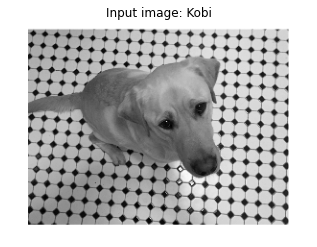

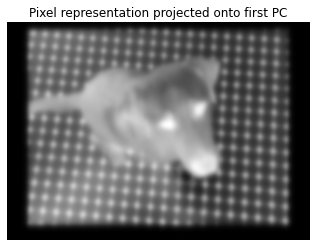

Clustering completed in 0.6132159233093262 seconds.


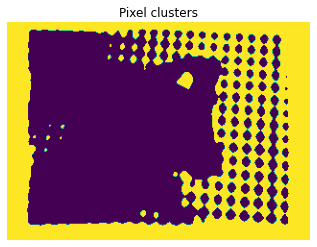

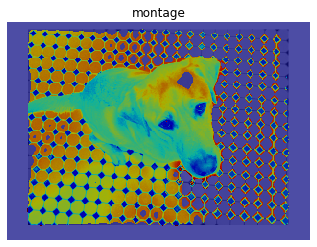

In [40]:

# Control settings
visFlag       = False    #  Set to true to visualize filter responses.
smoothingFlag = True   #  Set to true to postprocess filter outputs.

image_id = "Kobi"
img = load_image(image_id) # load an image with the Polar bear
img = img.astype('float32')

show_image(img, f'Input image: {image_id}')

#1. Convert to grayscale if necessary
if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Design array of Gabor Filters
# In this code section, you will create a Gabor Filterbank. A filterbank is
# a collection of filters with varying properties (e.g. {shape, texture}).
# A Gabor filterbank consists of Gabor filters of distinct orientations
# and scales. We will use this bank to extract texture information from the
# input image. 

numRows, numCols = img.shape

# Estimate the minimum and maximum of the wavelengths for the sinusoidal
# carriers. 
# ** This step is pretty much standard, therefore, you don't have to
#    worry about it. It is cycles in pixels. **   
lambdaMin = 4/np.sqrt(2)
lambdaMax = np.sqrt(abs(numRows)**2 + abs(numCols)**2)

# Specify the carrier wavelengths.  
# (or the central frequency of the carrier signal, which is 1/lambda)
n = np.floor(np.log2(lambdaMax/lambdaMin))
lambdas = 2**np.arange(0, (n-2)+1) * lambdaMin

# Define the set of orientations for the Gaussian envelope.
dTheta       = 2 * np.pi/8                  # \\ the step size
orientations = np.arange(0, np.pi+dTheta, dTheta)        

# Define the set of sigmas for the Gaussian envelope. Sigma here defines 
# the standard deviation, or the spread of the Gaussian. 
sigmas = np.array([1,2])

# Now you can create the filterbank. We provide you with a Python list
# called gaborFilterBank in which we will hold the filters and their
# corresponding parameters such as sigma, lambda and etc. 
# ** All you need to do is to implement createGabor(). Rest will be handled
#    by the provided code block. **
gaborFilterBank = []
tic = time.time()
for lmbda in lambdas:
    for sigma in sigmas:
        for theta in orientations:
            # Filter parameter configuration for this filter.
            psi    = 0
            gamma  = 0.5
            
            # Create a Gabor filter with the specs above. 
            # (We also record the settings in which they are created. )
            # // TODO: Implement the function createGabor() following
            #          the guidelines in the given function template.
            #          ** See createGabor.py for instructions ** //
            filter_config = {}
            filter_config["filterPairs"] = createGabor( sigma, theta, lmbda, psi, gamma )
            filter_config["sigma"]       = sigma
            filter_config["lmbda"]       = lmbda
            filter_config["theta"]       = theta
            filter_config["psi"]         = psi
            filter_config["gamma"]       = gamma
            gaborFilterBank.append(filter_config)
ctime = time.time() - tic

print('--------------------------------------\n \t\tDetails\n--------------------------------------')
print(f'Total number of filters       : {len(gaborFilterBank)}')
print(f'Number of scales (sigma)      : {len(sigmas)}')
print(f'Number of orientations (theta): {len(orientations)}')
print(f'Number of carriers (lambda)   : {len(lambdas)}')
print(f'---------------------------------------')
print(f'Filter bank created in {ctime} seconds.')
print(f'---------------------------------------')

# Filter images using Gabor filter bank using quadrature pairs (real and imaginary parts)
# You will now filter the input image with each complex Gabor filter in 
# gaborFilterBank structure and store the output in the cell called 
# featureMaps. 
# // Hint-1: Apply both the real imaginary parts of each kernel 
#            separately in the spatial domain (i.e. over the image). //
# // Hint-2: Assign each output (i.e. real and imaginary parts) in
#            variables called real_out and imag_out. //
# // Hint-3: Use built-in cv2 function, filter2D, to convolve the filter
#            with the input image. Check the options for padding. Find 
#            the one that works well. You might want to
#            explain what works better and why shortly in the report.
featureMaps = []
for gaborFilter in gaborFilterBank:
    # gaborFilter["filterPairs"] has two elements. One is related to the real part 
    # of the Gabor Filter and the other one is the imagineray part.
    real_out = cv2.filter2D(src=img,ddepth=-1,kernel=gaborFilter['filterPairs'][:,:,0])   # \\TODO: filter the grayscale input with real part of the Gabor
    imag_out = cv2.filter2D(src=img,ddepth=-1,kernel=gaborFilter['filterPairs'][:,:,1])  # \\TODO: filter the grayscale input with imaginary part of the Gabor
    featureMaps.append(np.stack((real_out, imag_out), 2))
    
    # Visualize the filter responses if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(real_out)    # Real
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(imag_out)    # Real
        title = "Im[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")
        plt.show()

# Compute the magnitude
# Now, you will compute the magnitude of the output responses.
# \\ Hint: (real_part^2 + imaginary_part^2)^(1/2) \\
featureMags = []
for i, fm in enumerate(featureMaps):
    real_part = fm[...,0]
    imag_part = fm[...,1]
    mag = np.sqrt(np.square(real_part) +np.square(imag_part))  # \\TODO: Compute the magnitude here
    featureMags.append(mag)
    
    # Visualize the magnitude response if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mag.astype(np.uint8))    # visualize magnitude
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilterBank[i]["lmbda"], 
                                                                                                 gaborFilterBank[i]["theta"], 
                                                                                                 gaborFilterBank[i]["sigma"])
        ax.set_title(title)
        ax.axis("off")

# Prepare and Preprocess features 
# You can think of each filter response as a sort of feature representation
# for the pixels. Now that you have numFilters = |gaborFilterBank| filters, 
# we can represent each pixel by this many features. 
# \\ Q: What kind of features do you think gabor filters might correspond to? 

# You will now implement a smoothing operation over the magnitude images in
# featureMags. 
# \\ Hint: For each i in [1, length(featureMags)], smooth featureMags{i}
#          using an appropriate first order Gaussian kernel.
# \\ Hint: cv2 filter2D function is helpful here.   
features = np.zeros(shape=(numRows, numCols, len(featureMags)))
if smoothingFlag:
    
    # \\TODO:
    for i in range(1,len(featureMags)):
        features[:,:,i] = cv2.filter2D(src=featureMags[i], ddepth=-1, kernel=gauss2D(1, 1, 3))
    #FOR_LOOP
        # i)  filter the magnitude response with appropriate Gaussian kernels
        # ii) insert the smoothed image into features[:,:,j]
    #END_FOR
else:
    # Don't smooth but just insert magnitude images into the matrix
    # called features.
    for i, fmag in enumerate(featureMags):
        features[:,:,i] = fmag


# Reshape the filter outputs (i.e. tensor called features) of size 
# [numRows, numCols, numFilters] into a matrix of size [numRows*numCols, numFilters]
# This will constitute our data matrix which represents each pixel in the 
# input image with numFilters features.  
features = np.reshape(features, newshape=(numRows * numCols, -1))
print(f"features: {features.shape}")

# Standardize features. 
# \\ Hint: see http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing for more information.

features = (features - np.mean(features)) / np.std(features)  
  # \\ TODO: i)  Implement standardization on matrix called features.
                 #          ii) Return the standardized data matrix.


# (Optional) Visualize the saliency map using the first principal component 
# of the features matrix. It will be useful to diagnose possible problems 
# with the pipeline and filterbank.

transformed_feature = PCA(n_components=1).fit_transform(features) # select the first component
transformed_feature = np.ascontiguousarray(transformed_feature, dtype=np.float32)
feature2DImage = np.reshape(transformed_feature,newshape=(numRows,numCols))
plt.figure()
plt.title(f'Pixel representation projected onto first PC')
plt.imshow(feature2DImage, cmap='gray')
plt.axis("off") 
plt.show()

# Apply k-means algorithm to cluster pixels using the data matrix,
# features. 
# \\ Hint-1: search about sklearn kmeans function https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.
# \\ Hint-2: use the parameter k defined in the first section when calling
#            sklearn's built-in kmeans function.
from sklearn.cluster import KMeans
tic = time.time()
pixLabels = KMeans(2).fit(features).labels_  # \\TODO: Return cluster labels per pixel
ctime = time.time() - tic
print(f'Clustering completed in {ctime} seconds.')



# Visualize the clustering by reshaping pixLabels into original grayscale
# input size [numRows numCols].
pixLabels = np.reshape(pixLabels, newshape=(numRows, numCols))
plt.figure()
plt.title(f'Pixel clusters')
plt.imshow(pixLabels)
plt.axis("off") 
plt.show()


# Use the pixLabels to visualize segmentation.
Aseg1 = np.zeros_like(img)
Aseg2 = np.zeros_like(img)
BW = pixLabels == 1  # check for the value of your labels in pixLabels (could be 1 or 0 instead of 2)
#BW = np.repeat(BW[:, :, np.newaxis], 3, axis=2) # do this only if you have 3 channels in the img
Aseg1[BW] = img[BW]
Aseg2[~BW] = img[~BW]

plt.figure()
plt.title(f'montage')
plt.imshow(Aseg1, 'gray', interpolation='none')
plt.imshow(Aseg2, 'jet',  interpolation='none', alpha=0.7)
plt.axis("off")
plt.show()